In [2]:
import aux_fun as functions
import SXS_module as sxs
import numpy as np
import matplotlib.pyplot as plt
import rdown_pe as rd_pe
from scipy.optimize import minimize
import qnm

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
qnm.download_data()

data-0.4.0.tar.bz2: 0.00B [00:00, ?B/s]

Trying to fetch https://duetosymmetry.com/files/qnm/data-0.4.0.tar.bz2


data-0.4.0.tar.bz2: 94.6MB [02:05, 751kB/s]                                                                                                                                                                 


Trying to decompress file /work/francisco.jimenez/.cache/qnm/data-0.4.0.tar.bz2
Data directory /work/francisco.jimenez/.cache/qnm/data contains 860 pickle files


In [57]:
s, l, m = [(-2,-2,-2, -2),(2,2,3,4),(2,1,3,4)]
mode_list = [(s[i], l[i], m[i], n) for n in np.arange(0,2) for i in range(len(m))]
modes_spec = { ind : qnm.modes_cache(*ind) for ind in mode_list }

In [79]:
def QNM_spectrum(l,m,n,mass,spin):
    """ It computes the RD frequencies and damping times in NR units.
    """  
    omegas_new=modes_spec[-2,l,m,n](spin)[0]
    w_m_a = (np.real(omegas_new))/mass
    tau_m_a=-1/(np.imag(omegas_new))*mass

    return (np.array([w_m_a]), np.array([tau_m_a]))


def rd_model_wtau_fixed(theta):
    """RD model parametrized with the damping time tau and with the QNM spectrum fixd to GR. 
    """ 
    dim=int(len(theta)/2)
    xvars = theta[ : (dim)]
    yvars = theta[(dim) : 2*(dim)]
    tau=qnmspec[1]
    w=qnmspec[0]
    ansatz = 0
    for i in range (0,dim):
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-time/tau[i]) * (np.cos(w[i]*time)+1j*np.sin(w[i]*time))
    return ansatz

def log_likelihood(theta):
    """chi2 likelihood.
    """ 
    datare = data.real
    dataim = data.imag
    modelev = rd_model_wtau_fixed(theta)
    modelevre= modelev.real
    modelevim= modelev.imag
    
    result=-0.5*np.sum((datare - modelevre)**2+(dataim - modelevim)**2)    
    if np.isnan(result):
        return -np.inf
    return result

In [43]:
# select non-precessing cases
import importlib
importlib.reload(sxs)
sxs_root_folder="/work/francisco.jimenez/SXS/data"
conditions=np.asarray([['BHBH',None],['Non-Precessing',None],['Eccentricity',['>=0.','<=0.001']]])
values=sxs.SXS_Catalogue_Select_cases(sxs_root_folder,conditions,sortcolumn=2,best_resolution=True,verbose=True)

/work/francisco.jimenez/virtualenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Found  2019 metadata.json files
              Tag         q $\chi_{eff}$ $\chi_{p}$                                              name
0    SXS:BBH:0226  0.999833    -0.199848        0.0  BBH_SKS_d17.1_q1_sA_0_0_0.500_sB_0_0_-0.900/Lev5
1    SXS:BBH:0219  0.999837     0.199912        0.0  BBH_SKS_d16.1_q1_sA_0_0_-0.500_sB_0_0_0.900/Lev5
2    SXS:BBH:2100  0.999849    -0.199833        0.0                                         0226/Lev4
3    SXS:BBH:2093  0.999852     0.199885        0.0                                         0219/Lev4
4    SXS:BBH:0325  0.999915    -0.399842        0.0                                         0000/Lev3
..            ...       ...          ...        ...                                               ...
501  SXS:BBH:1108   9.19995    -0.000002        0.0         BBH_CFMS_d13_q9.20_sA_0_0_0_sB_0_0_0/Lev5
502  SXS:BBH:0302  9.499946     0.000001        0.0       BBH_CFMS_d11.3_q9.50_sA_0_0_0_sB_0_0_0/Lev5
503  SXS:BBH:0196  9.662816    -0.000001        0.

In [44]:
hd5files=sxs.find_hd5files(values[:,0],sxs_root_folder)

In [47]:
len(values),len(hd5files)

(506, 506)

In [59]:
modes=np.array([[2,2],[2,1],[3,3],[4,4]])

In [49]:
wave={}
for i in range(len(values)):
    tag=values[i,0]
    wave[tag]=sxs.Generate_SXS_Waveform(hd5files[i],modes,
                                        extrapolation_order=3,zero_align=False,resample=False,
                                        sampling_rate=0.5,modes_combined=False,inclination=0,
                                        phase=0,RD=True,toffset=10)

/work/francisco.jimenez/virtualenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/work/francisco.jimenez/virtualenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


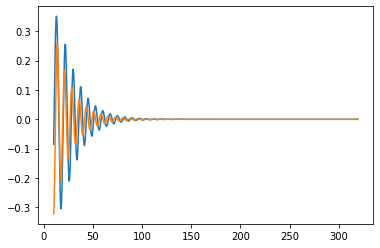

In [81]:
index=25
qnmspec=QNM_spectrum(2,2,0,values[index,-3],values[index,-2])
time=wave[values[index,0]][0][:,0]
data=wave[values[index,0]][0][:,1]

rdowlike=log_likelihood
nll = lambda *args: -rdowlike(*args)
initial = np.array([0,0])

soln = minimize(nll, initial)
vars_ml=soln.x
plt.plot(time,data.imag)
plt.plot(time,rd_model_wtau_fixed(vars_ml).imag)

In [95]:
vars_ml22=[None]*len(values)
vars_ml21=[None]*len(values)
vars_ml33=[None]*len(values)
vars_ml44=[None]*len(values)

initial22=[1,1]
initial21=[1,1]
initial33=[0.1,3]
initial44=[0.1,3]
bnds = ((None, None), (None, None))
for i in range(len(values)):
    time=wave[values[i,0]][0][:,0].real

    qnmspec=QNM_spectrum(2,2,0,values[i,-3],values[i,-2])
    data=wave[values[i,0]][0][:,1]
    soln = minimize(nll, initial22,method='SLSQP', bounds=bnds)
    vars_ml22[i]=list(soln.x)
    
    qnmspec=QNM_spectrum(2,1,0,values[i,-3],values[i,-2])
    data=wave[values[i,0]][1][:,1]
    soln = minimize(nll, initial21,method='SLSQP', bounds=bnds)
    vars_ml21[i]=list(soln.x)
        
    qnmspec=QNM_spectrum(3,3,0,values[i,-3],values[i,-2])
    data=wave[values[i,0]][2][:,1]
    soln = minimize(nll, initial33,method='SLSQP', bounds=bnds)
    vars_ml33[i]=list(soln.x)
    
    qnmspec=QNM_spectrum(4,4,0,values[i,-3],values[i,-2])
    data=wave[values[i,0]][3][:,1]
    soln = minimize(nll, initial44,method='SLSQP', bounds=bnds)
    vars_ml44[i]=list(soln.x)

In [96]:
vars_ml22=np.array(vars_ml22)
vars_ml21=np.array(vars_ml21)
vars_ml33=np.array(vars_ml33)
vars_ml44=np.array(vars_ml44)

Text(0, 0.5, '$A_{R}$')

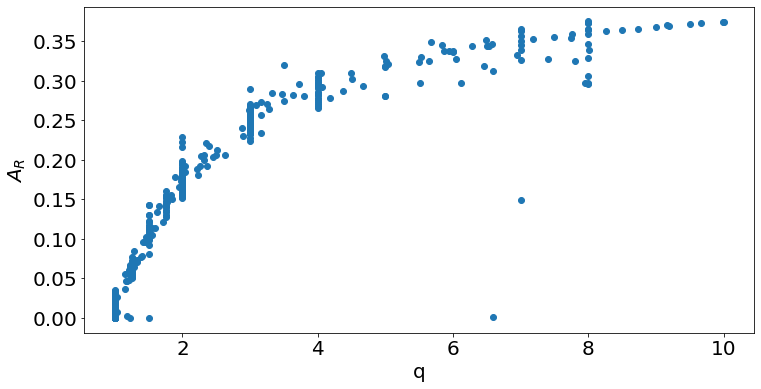

In [97]:
# plot amplitude
amprat=abs(vars_ml33[:,0]/vars_ml22[:,0])
fig, ax = plt.subplots(figsize=(12, 6))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
plt.plot(values[:,2],amprat,'o')
plt.xlabel('q',fontsize=20)
plt.ylabel(r'$A_{R}$',fontsize=20)

In [114]:
# Same but for the phase. I need to rotate the phi22 such is zero at t=0
phase22_0=vars_ml22[:,1]

vars_ml22_r=[None]*len(values)
vars_ml21_r=[None]*len(values)
vars_ml33_r=[None]*len(values)
vars_ml44_r=[None]*len(values)

initial22=[1,1]
initial21=[1,1]
initial33=[0.1,3]
initial44=[0.1,3]
bnds = ((None, None), (None, None))
for i in range(len(values)):
    time=wave[values[i,0]][0][:,0].real

    qnmspec=QNM_spectrum(2,2,0,values[i,-3],values[i,-2])
    data=wave[values[i,0]][0][:,1]*np.exp(-1j*phase22_0[i])
    soln = minimize(nll, initial22,method='SLSQP', bounds=bnds)
    vars_ml22_r[i]=list(soln.x)
    
    qnmspec=QNM_spectrum(2,1,0,values[i,-3],values[i,-2])
    data=wave[values[i,0]][1][:,1]*np.exp(-1j*2/2*phase22_0[i])
    soln = minimize(nll, initial21,method='SLSQP', bounds=bnds)
    vars_ml21_r[i]=list(soln.x)
        
    qnmspec=QNM_spectrum(3,3,0,values[i,-3],values[i,-2])
    data=wave[values[i,0]][2][:,1]*np.exp(-1j*3/2*phase22_0[i])
    soln = minimize(nll, initial33,method='SLSQP', bounds=bnds)
    vars_ml33_r[i]=list(soln.x)
    
    qnmspec=QNM_spectrum(4,4,0,values[i,-3],values[i,-2])
    data=wave[values[i,0]][3][:,1]*np.exp(-1j*4/2*phase22_0[i])
    soln = minimize(nll, initial44,method='SLSQP', bounds=bnds)
    vars_ml44_r[i]=list(soln.x)

In [115]:
vars_ml21_r=np.array(vars_ml21_r)
vars_ml22_r=np.array(vars_ml22_r)

vars_ml33_r=np.array(vars_ml33_r)
vars_ml44_r=np.array(vars_ml44_r)

Text(0, 0.5, '$A_{R}$')

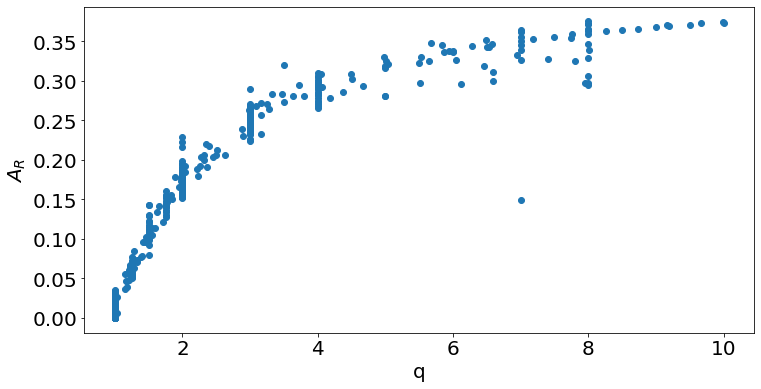

In [116]:
# plot amplitude. Shall be the same as before
amprat=abs(vars_ml33_r[:,0]/vars_ml22_r[:,0])
fig, ax = plt.subplots(figsize=(12, 6))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
plt.plot(values[:,2],amprat,'o')
plt.xlabel('q',fontsize=20)
plt.ylabel(r'$A_{R}$',fontsize=20)

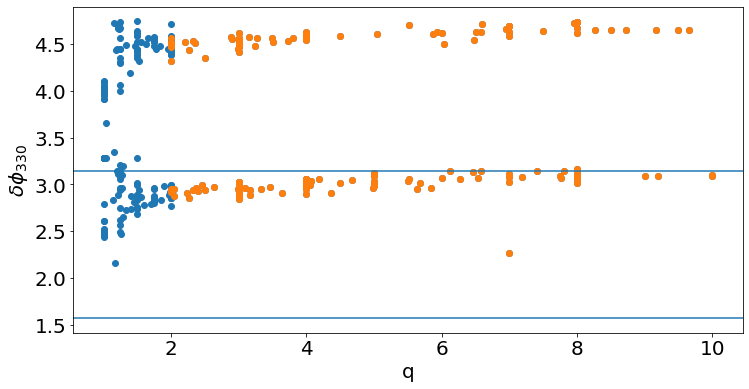

In [117]:
import math
phase_diff=vars_ml22_r[:,1]-vars_ml33_r[:,1]
phase_diff=phase_diff%(2*math.pi)
boolean = (phase_diff>1.6) & (values[:,2]>2)
fig, ax = plt.subplots(figsize=(12, 6))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
plt.plot(values[:,2],phase_diff,'o')
plt.plot(values[:,2][boolean],phase_diff[boolean],'o')

plt.xlabel('q',fontsize=20)
plt.ylabel(r'$\delta\phi_{330}$',fontsize=20)
plt.axhline(np.pi)
plt.axhline(np.pi/2)

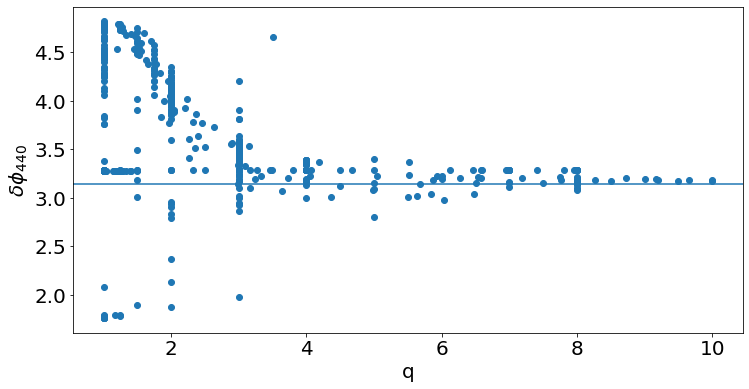

In [118]:
phase_diff=vars_ml22_r[:,1]-vars_ml44_r[:,1]
phase_diff=phase_diff%(2*math.pi)

fig, ax = plt.subplots(figsize=(12, 6))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
plt.plot(values[:,2],phase_diff,'o')
plt.xlabel('q',fontsize=20)
plt.ylabel(r'$\delta\phi_{440}$',fontsize=20)
plt.axhline(np.pi)

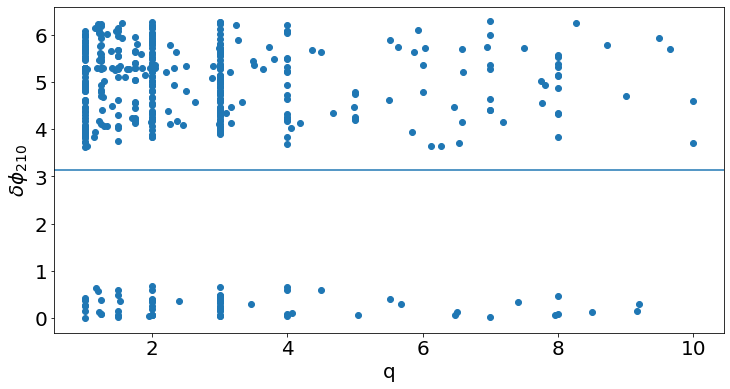

In [119]:
phase_diff=vars_ml22_r[:,1]-vars_ml21_r[:,1]
phase_diff=phase_diff%(2*math.pi)

fig, ax = plt.subplots(figsize=(12, 6))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
plt.plot(values[:,2],phase_diff,'o')
plt.xlabel('q',fontsize=20)
plt.ylabel(r'$\delta\phi_{210}$',fontsize=20)
plt.axhline(np.pi)

In [142]:
test=np.array([QNM_spectrum(2,2,n,values[index,-3],values[index,-2]) for n in range(2)]).T
flat_list = [item for sublist in qnm_unformat for item in sublist]
flat_list

[array([0.84691631, 0.84497985]), array([16.6801982 ,  5.55187876])]

/work/francisco.jimenez/virtualenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/work/francisco.jimenez/virtualenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([1.19941264, 6.51722045, 1.55638129, 4.21618666])

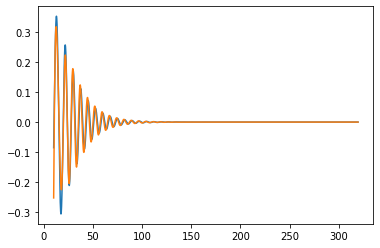

In [143]:
# Now fitting the 221

index=25
qnm_unformat=np.array([QNM_spectrum(2,2,n,values[index,-3],values[index,-2]) for n in range(2)]).T
qnmspec=[item for sublist in qnm_unformat for item in sublist]
time=wave[values[index,0]][0][:,0]
data=wave[values[index,0]][0][:,1]

rdowlike=log_likelihood
nll = lambda *args: -rdowlike(*args)
initial = np.array([1,3,3,3])

soln = minimize(nll, initial)
vars_ml=soln.x
plt.plot(time,data.imag)
plt.plot(time,rd_model_wtau_fixed(vars_ml).imag)
vars_ml

In [144]:
# Now fitting the 221
vars_ml221=[None]*len(values)
rdowlike=log_likelihood
nll = lambda *args: -rdowlike(*args)
initial22=[1,1,4,3]


for i in range(len(values)):
    time=wave[values[i,0]][0][:,0].real
    qnm_unformat=np.array([QNM_spectrum(2,2,n,values[index,-3],values[index,-2]) for n in range(2)]).T
    qnmspec=[item for sublist in qnm_unformat for item in sublist]

    data=wave[values[i,0]][0][:,1]
    soln = minimize(nll, initial22,method='SLSQP')
    vars_ml221[i]=list(soln.x)
    

In [145]:
vars_ml221=np.array(vars_ml221)

(0.0, 10.0)

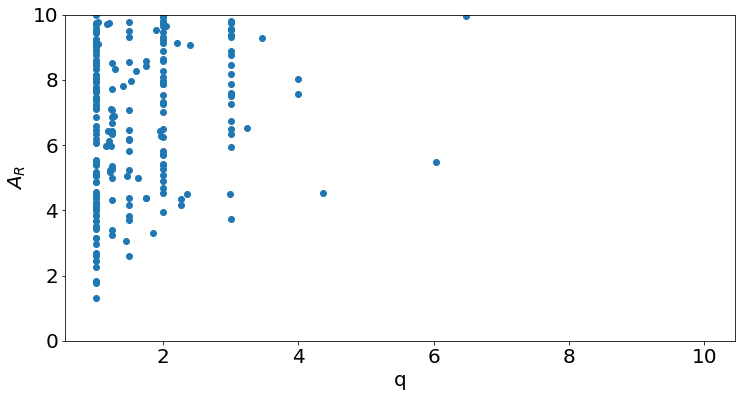

In [146]:
# plot amplitude  221/220
amprat=abs(vars_ml221[:,2]/vars_ml221[:,0])
fig, ax = plt.subplots(figsize=(12, 6))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
plt.plot(values[:,2],amprat,'o')
plt.xlabel('q',fontsize=20)
plt.ylabel(r'$A_{R}$',fontsize=20)
plt.ylim(0,10)

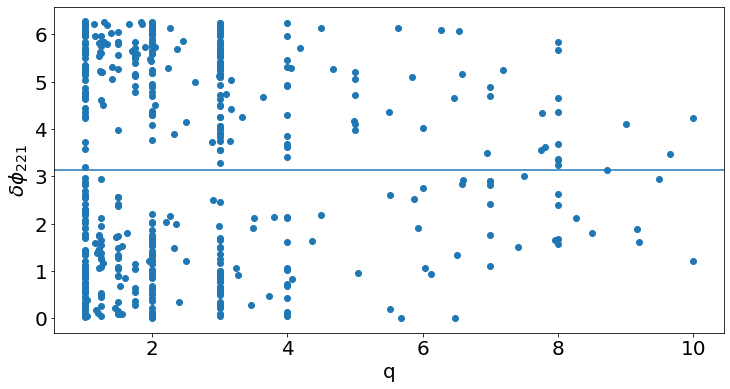

In [147]:
phase_diff=vars_ml221[:,1]-vars_ml221[:,3]
phase_diff=phase_diff%(2*math.pi)

fig, ax = plt.subplots(figsize=(12, 6))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
plt.plot(values[:,2],phase_diff,'o')
plt.xlabel('q',fontsize=20)
plt.ylabel(r'$\delta\phi_{221}$',fontsize=20)
plt.axhline(np.pi)

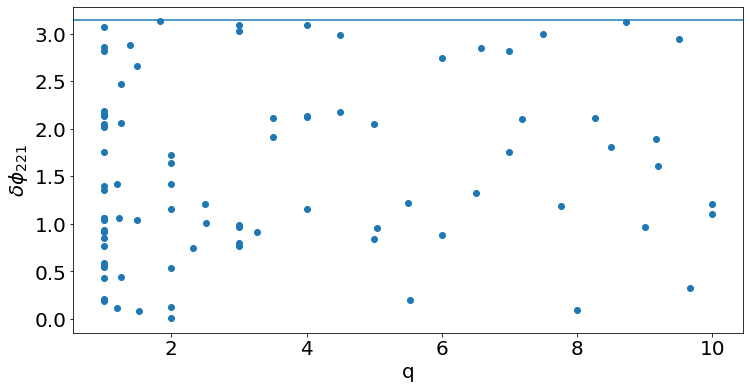

In [148]:
# plot subspaces
phase_diff=vars_ml221[:,1]-vars_ml221[:,3]
phase_diff=phase_diff%(math.pi)

fig, ax = plt.subplots(figsize=(12, 6))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
    
boolean=np.abs(values[:,3])<0.01
plt.plot(values[:,2][boolean],phase_diff[boolean],'o')
plt.xlabel('q',fontsize=20)
plt.ylabel(r'$\delta\phi_{221}$',fontsize=20)
plt.axhline(np.pi)